In [52]:
#Date: 2/9
#Version: 1.3
#Added t-SNE visualization

# Add evaluation metric and also split textual and intuitive classfication
#1. Changed where tfidf is used. Originally it was for training set. Now we use tfidf for the whole corpus and then select those we need to train out of the matrix.
#2. Distinguish textual and intuitive task
#3. Add a simple accuracy as evaluation of performance.
#4. Changed parameters in tfidf like minimum frequency and maximum of features in a corpus.

import numpy as np  # linear algebra
import math  
import time
import nltk
import scipy
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer   #see, sees, saw -> see
import re  # to get process information
import time
import matplotlib.pyplot as plt
import gc
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE

In [53]:
def get_tokens(text):
	lowers = text.lower()
	lowers = re.sub("[\:\.\!\/_|,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+","",lowers)    		#get rid of symbols
	tokens = nltk.word_tokenize(lowers)											#question here: lemma?big numbers?
	list_stopWords=list(set(stopwords.words('english')))
	tokens = [w for w in tokens if not w in list_stopWords]				#get rid of stopwords
	return tokens


#[['a','b','c'],['d','e','f']]   -------> ['a b c','d e f'] for tfidf format
def two2one(two_d):
	one_d = []
	for i in range(len(two_d)):
		for j in range(len(two_d[i])):
			if j ==0:
				temp = two_d[i][j]
			else:
				temp += ' '
				temp += two_d[i][j]
		one_d.append(temp)	
	return one_d

#we may not need this
def testreshape(train,test):
	temp_test_x = test_x.toarray()
	temp_test_x = temp_test_x.tolist()
	print(len(temp_test_x),len(temp_test_x[0]))
	for row in temp_test_x:
		for i in range(len(train[0]) - len(test[0])):
			row.append(0)
	print(len(temp_test_x),len(temp_test_x[0]))
	test_x = scipy.sparse.csr_matrix(temp_test_x)
	return test_x

#Evaluation
def get_accuracy(predict, groundtruth):
	count = 0
	for i in range(len(predict)):
		if predict[i] == groundtruth[i]:
			count += 1
	accuracy = count*1.0/len(predict)
	return accuracy

#This is for visualization
#def cluster_scatter():
    

In [54]:
#read a file
starttime = time.time()
file = open("ObesitySen1")
file_train = open("train_groundtruth.xml")
file_test = open("test_groundtruth.xml")
try:
	all_text = file.read()
	train_truth = file_train.readlines()
	test_truth = file_test.readlines()
finally:
	file.close()
	file_train.close()
	file_test.close()

#break into lists
text = all_text.split('[report_end]')		#break into patient's individual records
text.pop(0)									#eliminate the first element because it is a Null

EHR4patients = []							#Each EHR refers a list which contains all the words inside the EHR
for i in range(len(text)):
	temp = get_tokens(text[i])
	EHR4patients.append(temp)

EHR_in_one = two2one(EHR4patients)

In [55]:
#build train and test set
id_pattern = re.compile('\d+')
obesity_pattern = re.compile('[NYUQ]')

test_textual_x_id = []
test_textual_y = []
for i in range(5593,6040):					#5593-6040
	temp_test_x_id = id_pattern.findall(test_truth[i])
	temp_test_y = obesity_pattern.findall(test_truth[i])
	test_textual_x_id.append(temp_test_x_id[0])
	test_textual_y.append(temp_test_y[0])

test_intui_x_id = []
test_intui_y = []
for i in range(13495,13988):					#13495-13988
	temp_test_x_id = id_pattern.findall(test_truth[i])
	temp_test_y = obesity_pattern.findall(test_truth[i])
	test_intui_x_id.append(temp_test_x_id[0])
	test_intui_y.append(temp_test_y[0])

train_textual_x_id = []
train_textual_y = []
for i in range(8722,9387):							#8722-9387 in the xml
	temp_train_x_id = id_pattern.findall(train_truth[i])
	temp_train_y = obesity_pattern.findall(train_truth[i])
	train_textual_x_id.append(temp_train_x_id[0])
	train_textual_y.append(temp_train_y[0])

train_intui_x_id = []
train_intui_y = []
for i in range(20162,20892):							#20162-20892 in the xml
	temp_train_x_id = id_pattern.findall(train_truth[i])
	temp_train_y = obesity_pattern.findall(train_truth[i])
	train_intui_x_id.append(temp_train_x_id[0])
	train_intui_y.append(temp_train_y[0])


In [56]:
# get tfidf score of words
vectorizer = TfidfVectorizer(max_df=0.95, min_df=3, max_features = 5000)
X = vectorizer.fit_transform(EHR_in_one)
print(time.time()-starttime, ":","tfidf done")
print(type(X))

10.442476749420166 : tfidf done
<class 'scipy.sparse.csr.csr_matrix'>


In [57]:
X = X.toarray()
print(len(X[0]))

5000


In [58]:
#find those train&test intui&textual in that tfidf matrix
train_textual_x = []
train_intui_x = []
for id in train_textual_x_id:
	train_textual_x.append(X[int(id)-1])
for id in train_intui_x_id:
	train_intui_x.append(X[int(id)-1])
test_textual_x = []
test_intui_x = []
for id in test_textual_x_id:
	test_textual_x.append(X[int(id)-1])
for id in test_intui_x_id:
	test_intui_x.append(X[int(id)-1])


print("textual training set size: ",len(train_textual_x),len(train_textual_x[0]))
print("textual testing set size: ",len(test_textual_x),len(test_textual_x[0]))
print("intuitive training set size: ",len(train_intui_x),len(train_intui_x[0]))
print("intuitive testing set size: ",len(test_intui_x),len(test_intui_x[0]))
print(time.time()-starttime, ":","train set & test set done")

train_textual_x = scipy.sparse.csr_matrix(train_textual_x)
test_textual_x = scipy.sparse.csr_matrix(test_textual_x)
train_intui_x = scipy.sparse.csr_matrix(train_intui_x)
test_intui_x = scipy.sparse.csr_matrix(test_intui_x)

gc.collect()

textual training set size:  665 5000
textual testing set size:  447 5000
intuitive training set size:  730 5000
intuitive testing set size:  493 5000
10.511680126190186 : train set & test set done


242

In [59]:
#training with SVM

svm_1 = SVC(kernel = 'rbf', C = 2,degree = 3, gamma = 0.5)
textual_training = svm_1.fit(train_textual_x, train_textual_y)
textual_pred = textual_training.predict(test_textual_x)
print(time.time()-starttime, ":","svm training for textual task done")
print('The parameters of the best model are: ')

svm_2 = SVC(kernel = 'rbf', C = 4, degree = 3, gamma = 0.5)
intui_training = svm_2.fit(train_intui_x, train_intui_y)
intui_pred = intui_training.predict(test_intui_x)
print(time.time()-starttime, ":","svm training for intuitive task done")

#print(intui_pred)
print("textual accuracy is: ",get_accuracy(textual_pred,test_textual_y))
print("intuitive accuracy is: ",get_accuracy(intui_pred,test_intui_y))

13.30884861946106 : svm training for textual task done
The parameters of the best model are: 
16.962710857391357 : svm training for intuitive task done
textual accuracy is:  0.7472035794183445
intuitive accuracy is:  0.7647058823529411


In [81]:
dense_textual_x = test_textual_x.toarray()
dense_intui_x = test_intui_x.toarray()

Well this part says something.
You can definitely see the result is not as good as we think. The logic here is:
1. WE try to use t-SNE(a visualization method to map a high-dimension thing to a low-dimension thing sso that we can see that in 2 dimensions)
2. Then mark the points a color depending on its label.
We should have seen points in a certain cluster possessing generally same color. 


However it was not, this indicated 2 possiblities:
1. t-SNE sucks. It fails to differentiate clusters correctly.
2. Feature extraction sucks so that t-SNE fails to affrentiate.
3. Prediction sucks in that we should predict labels(colors) approximately sharing distribution with clusters. But we did not so the prediction sucks.

Actually the 3 reason can be traced into 1 which is the second one, feature extraction.We cannot blame the classfier. There must be something wrong with the featrue extraction part (tf-idf part)

finished!


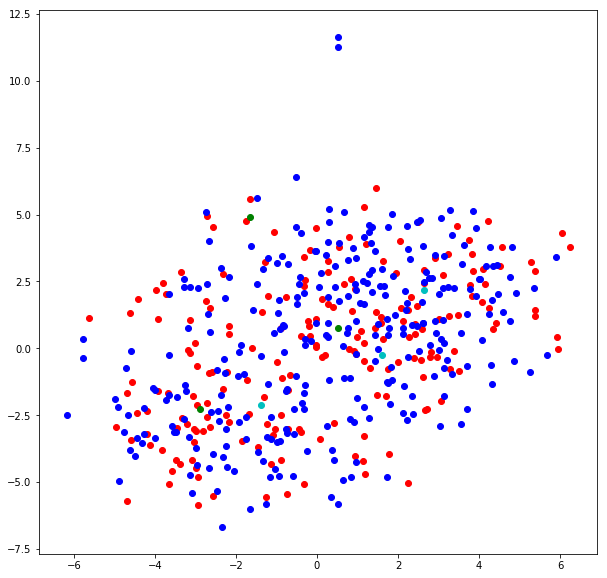

In [86]:
intui_vis = TSNE(n_components = 4, learning_rate = 100).fit_transform(dense_intui_x)
print("finished!")
#print(intui_vis)

intui_vis1 = []
intui_vis2 = []
intui_vis3 = []
intui_vis4 = []
for i in range(len(intui_vis)):
    if test_intui_y[i] == 'N':
        intui_vis1.append(intui_vis[i])
    elif test_intui_y[i] == 'Y':
        intui_vis2.append(intui_vis[i])
    elif test_intui_y[i] == 'Q':
        intui_vis3.append(intui_vis[i])
    else:
        intui_vis4.append(intui_vis[i])
intui_vis1 = np.array(intui_vis1)
intui_vis2 = np.array(intui_vis2)
intui_vis3 = np.array(intui_vis3)
intui_vis4 = np.array(intui_vis4)
plt.figure(figsize=(10, 10))
plt.scatter(intui_vis1[:, 0], intui_vis1[:, 1], color = 'c')
plt.scatter(intui_vis2[:, 0], intui_vis2[:, 1], color = 'r')
plt.scatter(intui_vis3[:, 0], intui_vis3[:, 1], color = 'g')
plt.scatter(intui_vis4[:, 0], intui_vis4[:, 1], color = 'b')
plt.show() 